#   OTIMIZAÇÃO E VISUALIZAÇÃO DE DADOS COM PYTHON: UM ESTUDO DE CASO DE ROTEAMENTO DE VEÍCULOS 

*Autores:* Douglas F. Cordeiro, Renata Moreira Limiro, Asteroide Santana, Eduardo Noronha de Andrade Freitas, Núbia Rosa Da Silva

Problema originalmente disponível em: https://www.mipwise.com/use-cases/woodler<br/>
Conjunto de dados disponível em: https://github.com/mipwise/use-cases/tree/main/woodler/data

## Formulação Matemática
Esta seção contêm a formulação matemática do problema.

### Dados de Entrada

#### Conjunto de índices
- $S=\{s_0, s_1, ..., s_n\}$ - Conjunto de locais, sendo $s_0$ o Centro de Distribuição.
- $K=\{s_0, s_1, ..., s_m\}$ - Conjunto de caminhões.

#### Parâmetros
* $d_{ij}$ - distância entre um local $s_i$ e um local $s_j$, sendo $i\neq j$;
* $c_i$ - demanda de um local $s_i \in S \setminus\{0\}$;
* $q_i$ - capacidade de um caminhão $k_i$;
* $p_i$ - custo variável de um caminhão $k_i$;
* $r_i$ - custo fixo de um caminhão $k_i$.


### Variáveis de Decisão

- $x_{i,j,k} \in \{0,1 \}$: variável binária que é igual a  1, se o caminhão $k$ visita e vai diretamente do local $i$ para o local $j$, e 0 em caso contrário.

- $z_k \in \{0,1\}$: variável binária que é igual 1 se o caminhã $k$ estiver sendo utilizado, e 0 em caso contrário.

### Restrições

* Restrição para garantir que cada localização receba apenas uma visita de um único veículo.:
$$\sum_{k \in K} \sum_{i \in S, i \neq j} x_{ijk} = 1, \quad \forall j \in S \backslash \{0\}.$$

* Restrição para garantir que os veículos saíam do CD

$$\sum_{j \in S\backslash\{0\}} x_{0jk} = 1, \quad  \forall k \in K.$$

* Restrição para garantir que o número de veículos que chega em um local seja o mesmo número dos que saem

$$\sum_{i \in S, i\neq j} x_{ijk} = \sum_{i \in S, i\neq j} x_{jik}, \quad \forall j \in S, \forall k \in K.$$

* Restrição que garante que a capacidade de entrega de cada veículo não exceda a sua capacidade máxima 
$$\sum_{i \in S} \sum_{j \in S, j\neq i} c_j\cdot x_{ijk} \leq q_k, \quad \forall k \in K.$$

* Restrição que garante que o custo fixo seja incluído no processo de minimização do objetivo
$$\sum_{j \in S\backslash\{0\}} x_{0jk} = z_k, \quad \forall k \in K.$$

### Função Objetivo

\begin{equation}
\text{Minimizar} \quad \sum_{k = 1}\sum_{i \in s}\sum_{j \in s} (r_k+p_k\cdot d_{ij})\cdot x_{ijk}
\end{equation}

### Formulação Final
$$
\begin{eqnarray}
\begin{array}{rcl}
& \text{Minimizar} & \sum_{k = 1}\sum_{i \in s}\sum_{j \in s} (r_k+p_k\cdot d_{ij})\cdot x_{ijk}\\
& \text{s.t.}& \sum_{k \in K} \sum_{i \in S, i \neq j} x_{ijk} = 1, \quad \forall j \in S \backslash \{0\},\\
&& \sum_{j \in S\backslash\{0\}} x_{0jk} = 1, \quad  \forall k \in K,\\
&& \sum_{i \in S, i\neq j} x_{ijk} = \sum_{i \in S, i\neq j} x_{jik}, \quad \forall j \in S, \forall k \in K,\\
&& \sum_{i \in S} \sum_{j \in S, j\neq i} c_j\cdot x_{ijk} \leq q_k, \quad \forall k \in K,\\
&& \sum_{j \in S\backslash\{0\}} x_{0jk} = z_k, \quad \forall k \in K,\\
&& x_{ijk} \geq 0, \quad \forall i, j, k,\\
&& z_k \geq 0, \quad \forall k.
\end{array}
\end{eqnarray}
$$

### Variáveis de Decisão Auxiliares

- $u_{ik}$	- Variável inteira que permite especificar a posição de um local $i$ na sequência de paradas, considerando ainda um caminhão  $k$ específico.

### Restrições Auxiliares

* Eliminação de sub-rotas (*sub-tours*):
$$u_{ik} - u_{jk} +1 \leq N(1-x_{ijk}).$$

## Codificação

### Instalação de bibliotecas adicionais

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install pulp

### Montagem do Google Drive para acesso ao conjunto de dados

Observação: caso o código seja utilizado fora do Collab, ignorar a próxima célula

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/IFG/MOA/PROJETO-FINAL/'

Mounted at /content/drive


### Bibiotecas

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pulp
import pandas as pd

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

### Função para plotar rotas

In [4]:
def plotPath(x_sol):
    plt.figure(figsize=(17,7))
    G = nx.DiGraph()

    edge_labels = {}

    for node in x_sol:
        origem  = node[0]
        destino = node[1]
        carga   = node[2]        

        G.add_edge(origem, destino)    
        edge_labels[origem, destino] = f'({carga})'   
    
    pos = graphviz_layout(G, prog='neato')    

    nx.draw(
        G, pos, edge_color='black', width=1, linewidths=1,
        node_size=1000, node_color='skyblue', alpha=0.9,
        labels={node: node for node in G.nodes()}
    )

    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=12,
        font_color='dodgerblue'
    )

    plt.show()

### Obtendo dados

In [5]:
dataset = {
            1: 'woodler_data_5_sites', 
            2: 'woodler_data_10_sites', 
            3: 'woodler_data_30_sites'}[3]

dataset_path   = f"{dir}DADOS/{dataset}.xlsx"
df_sites          = pd.read_excel(dataset_path, sheet_name='sites')
df_trucks         = pd.read_excel(dataset_path, sheet_name='trucks')
df_transit_matrix = pd.read_excel(dataset_path, sheet_name='transit_matrix')
df_orders         = pd.read_excel(dataset_path, sheet_name='orders')


# Limpando ocorrências de arcos reflexivos
df_transit_matrix = df_transit_matrix[
                        ~(
                            df_transit_matrix['Origin Site ID']==
                            df_transit_matrix['Dest. Site ID'])
                    ]
df_transit_matrix.reset_index(drop=True, inplace=True)

s = list(set(df_sites['Site ID'])) # Lista de locais
t = list(set(df_trucks['Truck ID']))    # Lista de caminhões

d   = dict(zip(zip(
                    df_transit_matrix['Origin Site ID'], 
                    df_transit_matrix['Dest. Site ID']), 
              df_transit_matrix['Distance (KM)'])) # Demandas

c = {i:df_orders[df_orders['Site ID']==i]['Volume (M3)'].sum() for i in s[1:]}
q = dict(zip(df_trucks['Truck ID'], df_trucks['Capacity (M3)'])) # Capacidade dos caminhões
p = dict(zip(df_trucks['Truck ID'], df_trucks['Variable Cost (dollar/KM)'])) # Custo variável dos caminhões
r = dict(zip(df_trucks['Truck ID'], df_trucks['Fixed Cost'])) # Custo fixo dos caminhões

x_keys = []
for i in d.keys():
    for k in t:
        x_keys.append(i + (k,))

y_keys = []
for l in s:
    for v in t:
        y_keys.append((l,v))

### Modelo

In [6]:
# Variáveis de Decisão
x = pulp.LpVariable.dicts(indices=x_keys, cat=pulp.LpBinary, name='FromToBy')
z = pulp.LpVariable.dicts(indices=t, cat=pulp.LpBinary, name='used')

# Criando o modelo
mdl = pulp.LpProblem("Woodler", pulp.LpMinimize)

# Função Objetivo: Minimizar o número de caminhões utilizados.
mdl.setObjective(
    pulp.lpSum(r[k]*z[k] + p[k]*d[i,j]* x[i,j,k] if i != j else 0
                          for k in t
                          for j in s
                          for i in s)
)

# =============================================================================#
# RESTRIÇÕES 
#
# (2) Restrição para garantir que cada localização receba apenas uma visita 
# de um único veículo.
for j in s[1:]:
    mdl.addConstraint(
        pulp.lpSum(x[i,j,k] for i in s if i!=j for k in t) == 1,
        name=f'oneVisit_{j}'
    )


# (3) Restrição para garantir que os veículos saíam do CD
for k in t:
    mdl.addConstraint(
        pulp.lpSum(x[0,j,k] for j in s[1:]) == 1,
        name=f'depart_{k}'
    )

# (4) Restrição para garantir que o número de veículos que chega em um local
# seja o mesmo número dos que saem
for i in s:
    for k in t:
        mdl.addConstraint(
            pulp.lpSum(x[i,j,k] for j in s if j!=i) == 
                pulp.lpSum(x[j,i,k] for j in s if j!=i),
            name=f'flow_{i,k}'
        )

# (5) Restrição que garante que a capacidade de entrega de cada veículo não 
# exceda a sua capacidade máxima 
for k in t:
    mdl.addConstraint(
        pulp.lpSum(c[j]*x[i,j,k] for i in s for j in s[1:] if j!=i) <= q[k],
        name=f'capacity_{k}'
    )


# (6) Restrição que garante que o custo fixo seja incluído no processo de
# minimização do objetivo
for k in t:
    mdl.addConstraint(
        pulp.lpSum(x[0,j,k] for j in s[1:]) == z[k],
        name=f'custof_{k}'
    )

# (7) Eliminação de subtours
# Miller–Tucker–Zemlin (MTZ) sub-tour elimination constraints
sub_tour_elimination_MTZ = True
if sub_tour_elimination_MTZ:
    u = pulp.LpVariable.dicts(indices=y_keys, 
                              cat=pulp.LpInteger, 
                              lowBound=0, 
                              upBound=len(s)-1, 
                              name='u')
    for i, j, k in x_keys:
        if j != 0:
            mdl.addConstraint(u[i,k] - u[j,k] + 1 <= len(s) * (1 - x[i,j,k]), name=f'mtz_{i,j,k}')
else:
    u = None


# Recuperando solução
time_limit = 60
mip_gap = 0.05
%time mdl.solve(pulp.PULP_CBC_CMD(timeLimit=time_limit, gapRel=mip_gap))

# =============================================================================#
print(mdl.objective.value(), pulp.LpStatus[mdl.status])

x_sol = {(i,j,k): x[i,j,k].value() for i,j,k in x_keys if x[i,j,k].value() != 0}
print('x_sol:', x_sol)

CPU times: user 554 ms, sys: 49.8 ms, total: 604 ms
Wall time: 37.5 s
5173663.915 Optimal
x_sol: {(0, 1, 3): 1.0, (0, 3, 7): 1.0, (0, 4, 1): 1.0, (0, 12, 9): 1.0, (0, 14, 4): 1.0, (0, 17, 2): 1.0, (0, 18, 10): 1.0, (0, 22, 5): 1.0, (0, 24, 8): 1.0, (0, 28, 6): 1.0, (1, 8, 3): 1.0, (2, 19, 2): 1.0, (3, 23, 7): 1.0, (4, 10, 1): 1.0, (5, 6, 7): 1.0, (6, 16, 7): 1.0, (7, 0, 3): 1.0, (8, 7, 3): 1.0, (9, 25, 8): 1.0, (10, 11, 1): 1.0, (11, 0, 1): 1.0, (12, 13, 9): 1.0, (13, 0, 9): 1.0, (14, 0, 4): 1.0, (15, 0, 5): 1.0, (16, 0, 7): 1.0, (17, 2, 2): 1.0, (18, 0, 10): 1.0, (19, 20, 2): 1.0, (20, 0, 2): 1.0, (21, 0, 6): 1.0, (22, 27, 5): 1.0, (23, 5, 7): 1.0, (24, 9, 8): 1.0, (25, 26, 8): 1.0, (26, 0, 8): 1.0, (27, 15, 5): 1.0, (28, 29, 6): 1.0, (29, 21, 6): 1.0}


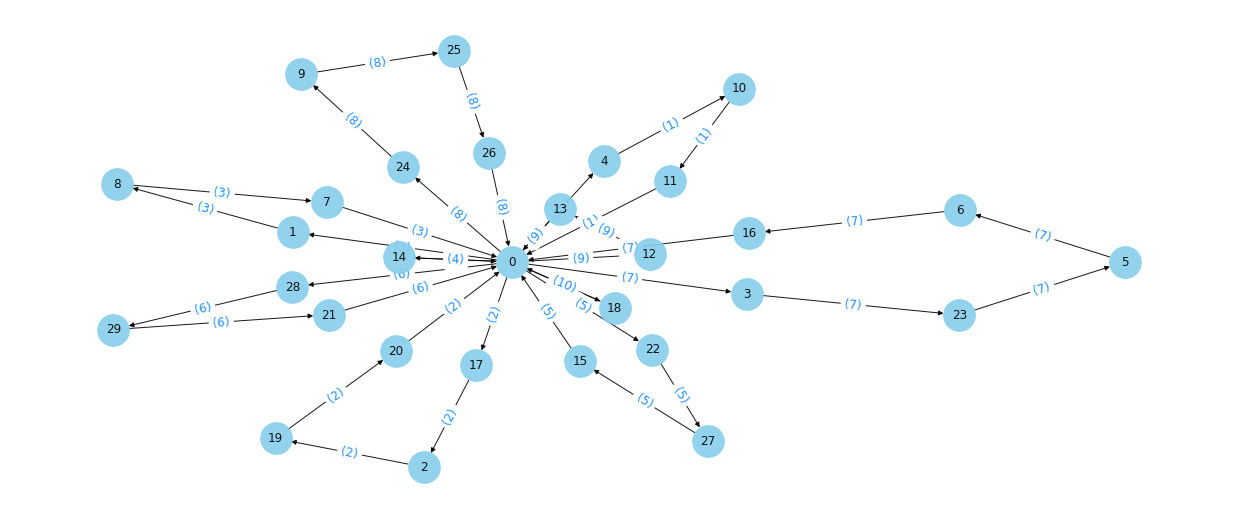

In [7]:
plotPath(x_sol)